### MP2 - Recognize daily goods - Solution ###

In [148]:
# Import modules

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from skimage.io import imsave, imread
from skimage import io,transform
from skimage.color import rgb2gray

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from torch.nn import CrossEntropyLoss
from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

In [149]:
torch.manual_seed(42)

In [150]:
# Read in data

train = pd.read_csv('./daily_goods/goods_train.csv')
test = pd.read_csv('./daily_goods/goods_test.csv')

print(f"Train data size: {train.shape} and Test data size: {test.shape}\n\n {train.head()}")

Train data size: (60000, 785) and Test data size: (10000, 785)

    label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel7

In [151]:
# Create a dictionary of label numbers to goods

good = {0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

print(good)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


Shape: (28, 28)
Label is: 2


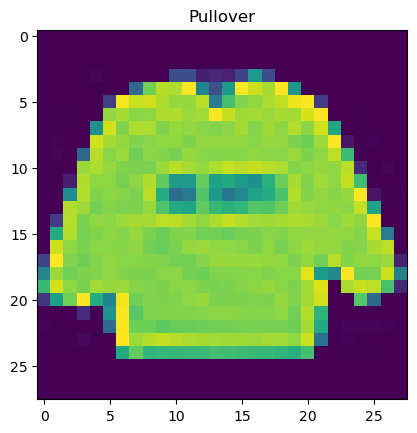

In [152]:
# Let us convert the pixels to get a sample image

sample_image = train.drop('label',axis=1) # Get the pixel array of all the 60000 images

sample_image = np.array(sample_image)[0].reshape(28,28) # Pick the first image
print(f"Shape: {sample_image.shape}")

# Corresponding label is
sample_label = train['label'].loc[0]
print(f"Label is: {sample_label}")

# Display image
plt.imshow(sample_image)
plt.title(good[sample_label])
plt.show()

In [153]:
# Create dataset class

class fashion(Dataset):
    def __init__(self,df):
        self.pixels = df.drop('label',axis=1)
        self.labels = df['label']
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        
        # Get 1 image at a time
        img = self.pixels.loc[idx]
        img = img.to_numpy()
        
        # Normalize
        img = img/255.0
        
        # Reshape to suit the CNN input dimensions (channels=1 as this is a grayscale)
        img = img.reshape(1,28,28)
        
        # Get corresponding label
        label = self.labels.loc[idx]
        
        return torch.from_numpy(img),torch.tensor(label)

In [154]:
# Instantiate dataset objects

train_dataset = fashion(train)
test_dataset = fashion(test)

In [155]:
# Test the get_item and len functions work properly

print(f"Numer of training data: {train_dataset.__len__()}")

# Get first training image
train_image = train_dataset.__getitem__(0)
print(f"Train Image Shape : {train_image[0].shape} and Label: {train_image[1]}")

Numer of training data: 60000
Train Image Shape : torch.Size([1, 28, 28]) and Label: 2


In [156]:
# Check if dataloader is working properly

train_loader = DataLoader(train_dataset,batch_size=512)
test_loader = DataLoader(test_dataset,batch_size=32)

for i in next(iter(train_loader)):
    print(f"Batch size Train: {i.size()}")


Batch size Train: torch.Size([512, 1, 28, 28])
Batch size Train: torch.Size([512])


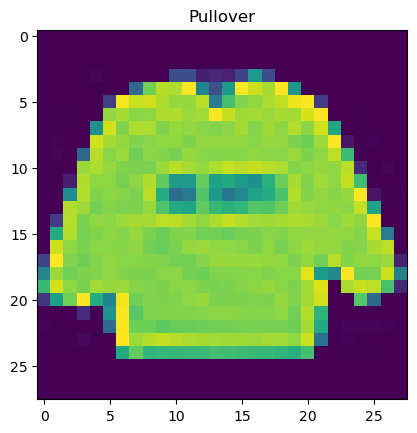

In [157]:
# Display image for idx 0

check_image = np.squeeze(train_image[0])
check_label = train_image[1]
plt.imshow(check_image)
plt.title(good[check_label.item()])
plt.show()


In [158]:
# Build CNN model

class goods(nn.Module):
    def __init__(self):
        super(goods, self).__init__()
        
        # Build the architecture
        
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=64,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128*7*7,1000)
        self.fc2 = nn.Linear(1000,50)
        self.fc3 = nn.Linear(50,10)
        
        # Pooling layer
        self.maxpool = nn.MaxPool2d(2)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Dropout layer
        self.dropout = nn.Dropout2d(0.25)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        
        
        x = x.view(-1,128*7*7)
        
        x = self.fc1(x)
        x = self.relu(x)
        
        if self.training:
            x = self.dropout(x) 
        
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x  

In [159]:
# Print summary after instantiating the model

model = goods()

summary(model,input_size=(1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]           9,280
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]          73,856
              ReLU-8            [-1, 128, 7, 7]               0
            Linear-9                 [-1, 1000]       6,273,000
             ReLU-10                 [-1, 1000]               0
        Dropout2d-11                 [-1, 1000]               0
           Linear-12                   [-1, 50]          50,050
           Linear-13                   [-1, 10]             510
Total params: 6,406,856
Trainable param

In [160]:
# Define parameters for training

epochs = 3

train_losses = []
test_losses = []

train_counter =[]
test_counter = [i*train_dataset.__len__() for i in range(epochs + 1)]


lr = 0.001

log_interval = 10

loss_fn = CrossEntropyLoss()
optimizer = Adam(params=model.parameters(),lr=lr)

In [161]:
# Training function

def train(epochs):
    model.train()
    
    # Read mini batch of training from dataloader and assign read in values to variables
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.float() #,target.long()
        
        # Clear the cache from past gradient values
        optimizer.zero_grad()
        
        # Predict on training data
        output = model(data)
        
        # Compute loss, back propogate and update weights
        loss = loss_fn(output,target)
        loss.backward()
        optimizer.step()
        
        # Bunch of code to print the progress every 10 epochs
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{train_dataset.__len__()} {100. * batch_idx* len(data) / train_dataset.__len__():.0f}%)]\tLoss: {loss.item():.6f}")
            
            # Store counter and loss values
            train_losses.append(loss.item())
            train_counter.append((batch_idx*512) + ((epoch-1)*train_dataset.__len__()))
            
            # Save the model and the weight parameters
            torch.save(optimizer.state_dict(), 'opt_dict.pth')
            torch.save(model.state_dict(), 'model_dict.pth')
            torch.save(model, 'model.pth')

In [162]:
# Test function

def test():
    model.eval()
    
    # Create variable to compute accuracy
    test_loss = 0
    correct = 0
    
    # Make sure gradient descent is not happening
    with torch.no_grad():
        for data, target in test_loader:
            data,target = data.float(),target.long()
            output = model(data)
            
            # Compute loss and add
            test_loss += loss_fn(output, target).item()
            
            # Store the predicted value
            pred = output.data.max(1, keepdim=True)[1]
            
            # Compute accuracy
            correct += pred.eq(target.data.view_as(pred)).sum()
    # Compute average test loss 
    test_loss /= len(test_loader)
    
    # Store loss values
    test_losses.append(test_loss)
    
    print(f"\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{test_dataset.__len__()} ({100. * correct / test_dataset.__len__():.0f}%)")

In [163]:
# Train test loop

# Include evaluation requirements

import time
from datetime import timedelta

start_time = time.time()

# Perform computations.
test()
for epoch in range(1, epochs + 1):
    train(epoch)
    test()
    
elapsed_time_secs = time.time() - start_time

msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))

print(msg)


Test set: Avg. loss: 2.3041, Accuracy: 1000/10000 (10%)
Train Epoch: 1 [0/60000 0%)]	Loss: 2.305358
Train Epoch: 1 [5120/60000 9%)]	Loss: 1.233211
Train Epoch: 1 [10240/60000 17%)]	Loss: 0.836332
Train Epoch: 1 [15360/60000 26%)]	Loss: 0.727579
Train Epoch: 1 [20480/60000 34%)]	Loss: 0.665667
Train Epoch: 1 [25600/60000 43%)]	Loss: 0.633362
Train Epoch: 1 [30720/60000 51%)]	Loss: 0.589701
Train Epoch: 1 [35840/60000 60%)]	Loss: 0.575718
Train Epoch: 1 [40960/60000 68%)]	Loss: 0.480761
Train Epoch: 1 [46080/60000 77%)]	Loss: 0.503394
Train Epoch: 1 [51200/60000 85%)]	Loss: 0.490604
Train Epoch: 1 [56320/60000 94%)]	Loss: 0.514430

Test set: Avg. loss: 0.4746, Accuracy: 8234/10000 (82%)
Train Epoch: 2 [0/60000 0%)]	Loss: 0.498808
Train Epoch: 2 [5120/60000 9%)]	Loss: 0.466311
Train Epoch: 2 [10240/60000 17%)]	Loss: 0.422763
Train Epoch: 2 [15360/60000 26%)]	Loss: 0.388870
Train Epoch: 2 [20480/60000 34%)]	Loss: 0.409562
Train Epoch: 2 [25600/60000 43%)]	Loss: 0.433273
Train Epoch: 2 [30

Text(0, 0.5, 'negative log likelihood loss')

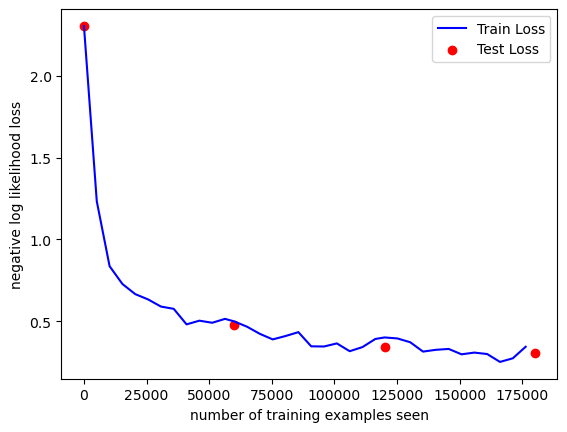

In [164]:
# Plot the loss curve

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

#### Function to predict on new images ####

In [165]:
# Function to predict on new images from trained model

def classify(model,image,classes,count):
    image = io.imread(image)
    print(image.shape)

    
    # Check if image has more than 2 channels (RGB type) and if yes convert to grayscale
    if len(image.shape) > 2:
        image = rgb2gray(image)
        
    
    # Transform to correct shape
    image = transform.resize(image,(28,28))
    #image = image/255
    print(image.shape)
    
    # Put in eval mode
    model = model.eval()
    optimizer.zero_grad()
    with torch.no_grad():
        image = torch.from_numpy(image) # Convert to torch tensor
        image = image.float() # of type float

        image = image.unsqueeze(0) # Add additional dimension to represent batch sie of 1

        # Predict
        output = model(image)
        print(f"Predictions:\n{output.data}\n")

        # Pick the value with the highest probability score in the output
        _,predicted = torch.max(output.data,1)
        print(f"Predicted Number:{good[classes[predicted.item()]]}\n")

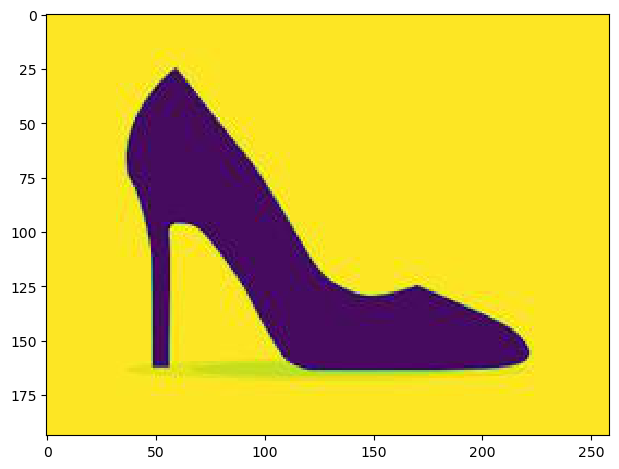

(194, 259, 3)
(28, 28)
Predictions:
tensor([[ 0.8499,  1.3744, -1.2197, -1.8514, -2.8977,  2.2640, -0.4045, -1.2012,
          5.1442,  4.7712]])

Predicted Number:Bag



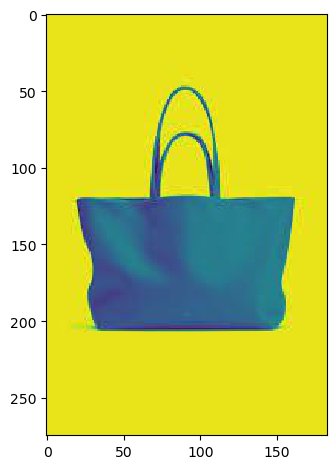

(275, 183, 3)
(28, 28)
Predictions:
tensor([[ 1.1259,  0.2816, -0.1723, -2.9385, -2.3046,  0.0606, -0.0727, -0.6339,
          5.6693,  3.7517]])

Predicted Number:Bag



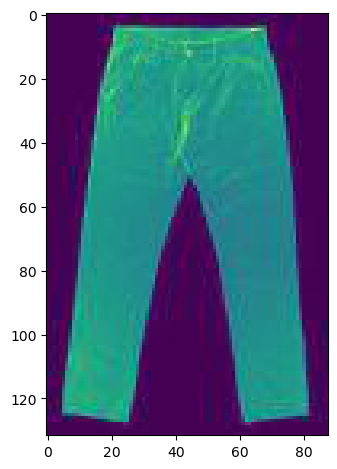

(132, 88, 3)
(28, 28)
Predictions:
tensor([[ 0.7958,  3.3202,  2.7089, -1.3967,  0.6261, -0.7243,  2.0716, -2.5060,
          1.2532, -0.3472]])

Predicted Number:Trouser



In [166]:
# Feed new unseen images

pics = ['shoe1.jpg','bag1.jpg','trouser1.jpg']

count = 0

# Define the classes
classes = [0,1,2,3,4,5,6,7,8,9]

read_in_images = []  # To store the images read in

# Call the prediction function
for i in pics:
    im = io.imread(i)
    io.imshow(im)
    plt.show()
    classify(model,i,classes,count)
    count += 1